# Visualize Influence of Number of Ensembles in a Comprehensive Summary

Evaluations where ensembling did not visually lead to a performance boost were discarded

<hr/>

#### Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

#### Constants

In [2]:
DATA_FOLDER = '../../../data/generated_by_notebooks/cumulative_performances/'
PLOT_FOLDER = './plots/'

initial_bins = range(1, 100)

#### Settings

In [3]:
mpl.rcParams['figure.dpi'] = 200

algorithms = ['rf', 'xgb', 'svm_rbf', 'shallow', 'dropout']
algorithm_to_name = {'rf' : 'RF', 'xgb' : 'XGB', 'svm_rbf' : 'SVM', 'shallow' : 'Shallow', 'dropout' : 'Deep'}

descriptors = ['maccs', 'ecfc', 'rdkit', 'cddd']
descriptor_names = ['MACCS', 'ECFC', 'RDKit', 'CDDD']
descriptor_to_name = {'maccs' : 'MACCS', 'ecfc' : 'ECFC', 'rdkit' : 'RDKit', 'cddd' : 'CDDD'}

# Names of the datasets that were already run
dataset_names = [
    'tetrahymena',
    'freesolv',
    'esol',
    'MMP2',
    'IL4',
    'F7',
    'O60674',
    'O14965',
    'P03372',
    'P04150',
    'P06401',
    'P11229',
    'P12931',
    'P16581',
    'P17252',
    'P18089',
    'P19327',
    'P21554',
    'P24530',
    'P25929',
    'P28335',
    'P28482',
    'P35968',
    'P41594',
    'P42345',
    'P47871',
    'P49146',
    'P61169',
    'Q05397',
    'Q16602',
    'P24941',
    'Q92731'
]

#### Functions

In [4]:
def load_cumulative_results_table(name, algorithm, performance):
    """Loads results for a specific dataset and modeling technique setting, for predictive or uncertainty performance."""
    path = f'{DATA_FOLDER}{performance}/{name}/{name}_{algorithm}.csv'
    table = pd.read_csv(path, sep=';').rename(columns={'Unnamed: 0': 'descriptor'})
    table['name'] = [get_dataset_name_correct(name) for _ in range(4)]
    table['algorithm'] = [algorithm_to_name[algorithm] for _ in range(4)]
    # Bring columns in correct order
    table = table[['name', 'algorithm'] + list(table.columns[:-2])]
    return table


def get_dataset_name_correct(name):
    """Formats a dataset name."""
    if name == 'tetrahymena':
        return 'Tetrahymena'
    elif name == 'freesolv':
        return 'FreeSolv'
    elif name == 'esol':
        return 'ESOL'
    else:
        return name

<hr/>

#### Load data

Collect all results in one big summary table

In [5]:
pred_summary_all = pd.DataFrame()
unct_summary_all = pd.DataFrame()

for name in dataset_names:
    for algorithm in algorithms:
        pred = load_cumulative_results_table(name, algorithm, 'predictive')
        unct = load_cumulative_results_table(name, algorithm, 'uncertainty')
        pred_summary_all = pd.concat([pred_summary_all, pred])
        unct_summary_all = pd.concat([unct_summary_all, unct])
        
pred_summary_all.replace('ECFC', 'MFC', inplace=True)
unct_summary_all.replace('ECFC', 'MFC', inplace=True)

pred_summary_all.index = range(1, len(pred_summary_all)+1)
unct_summary_all.index = range(1, len(unct_summary_all)+1)

pred_summary_all.index.name = '#'
unct_summary_all.index.name = '#'

Collect information which evaluations to exclude

In [6]:
excluded_folder = '../../../data/hand_crafted/visually_excluded_cumulative_performances.csv'
visually_excluded = pd.read_csv(excluded_folder, sep=';').set_index('#')

Exclude visually selected evaluations from summary tables

In [7]:
pred_summary = pred_summary_all[visually_excluded['Excluded from predictive evaluation'] != 'x']
unct_summary = unct_summary_all[visually_excluded['Excluded from uncertainty evaluation'] != 'x']

Format for heatmap

In [8]:
formatted_column_names = pred_summary['name'] + ', ' + pred_summary['algorithm'] + '/' + pred_summary['descriptor']

# Format predictive summary
pre_pred_summary_formatted = pred_summary.drop(columns=['name', 'algorithm', 'descriptor'])
pre_pred_summary_formatted['setting'] = formatted_column_names
pred_summary_formatted = pre_pred_summary_formatted.set_index('setting')

# Format uncertainty summary
pre_unct_summary_formatted = unct_summary.drop(columns=['name', 'algorithm', 'descriptor'])
pre_unct_summary_formatted['setting'] = formatted_column_names
unct_summary_formatted = pre_unct_summary_formatted.set_index('setting')

Check: At which member, 90% of the 100-member value was reached first?

In [9]:
# Predictive
pred_initial = pred_summary_formatted.T.iloc[0, :]
pred_last = pred_summary_formatted.T.iloc[-1, :]
pred_distance = pred_last - pred_initial
pred_90 = pred_initial + .9 * pred_distance
pred_reached = pred_summary_formatted.T >= pred_90

# Uncertainty
unct_initial = unct_summary_formatted.T.iloc[0, :]
unct_last = unct_summary_formatted.T.iloc[-1, :]
unct_distance = unct_last - unct_initial
unct_90 = unct_initial + .9 * unct_distance
unct_reached = unct_summary_formatted.T >= unct_90

Show for predictive performance

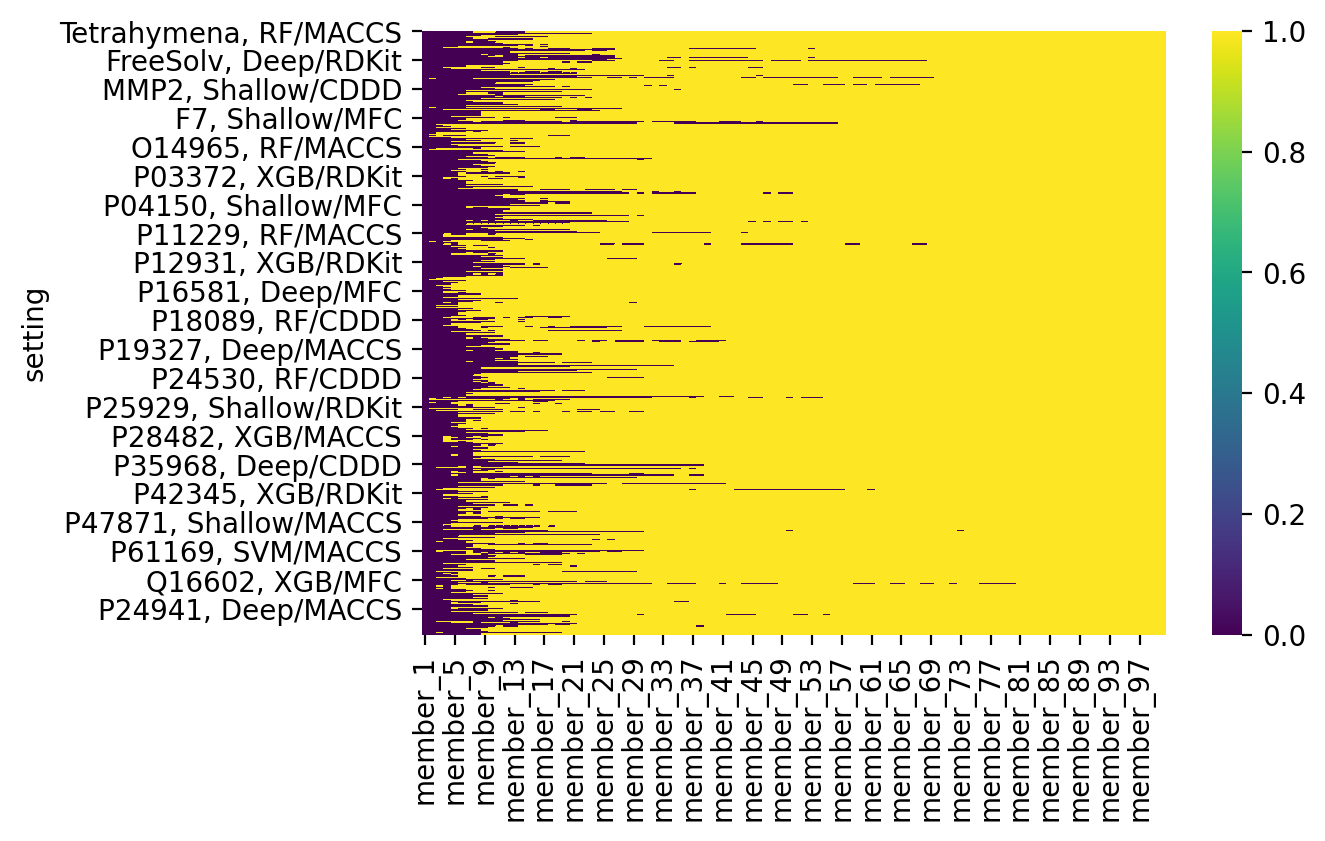

In [10]:
sns.heatmap(pred_reached.T, cmap='viridis')
plt.show()

Show for uncertainty performance

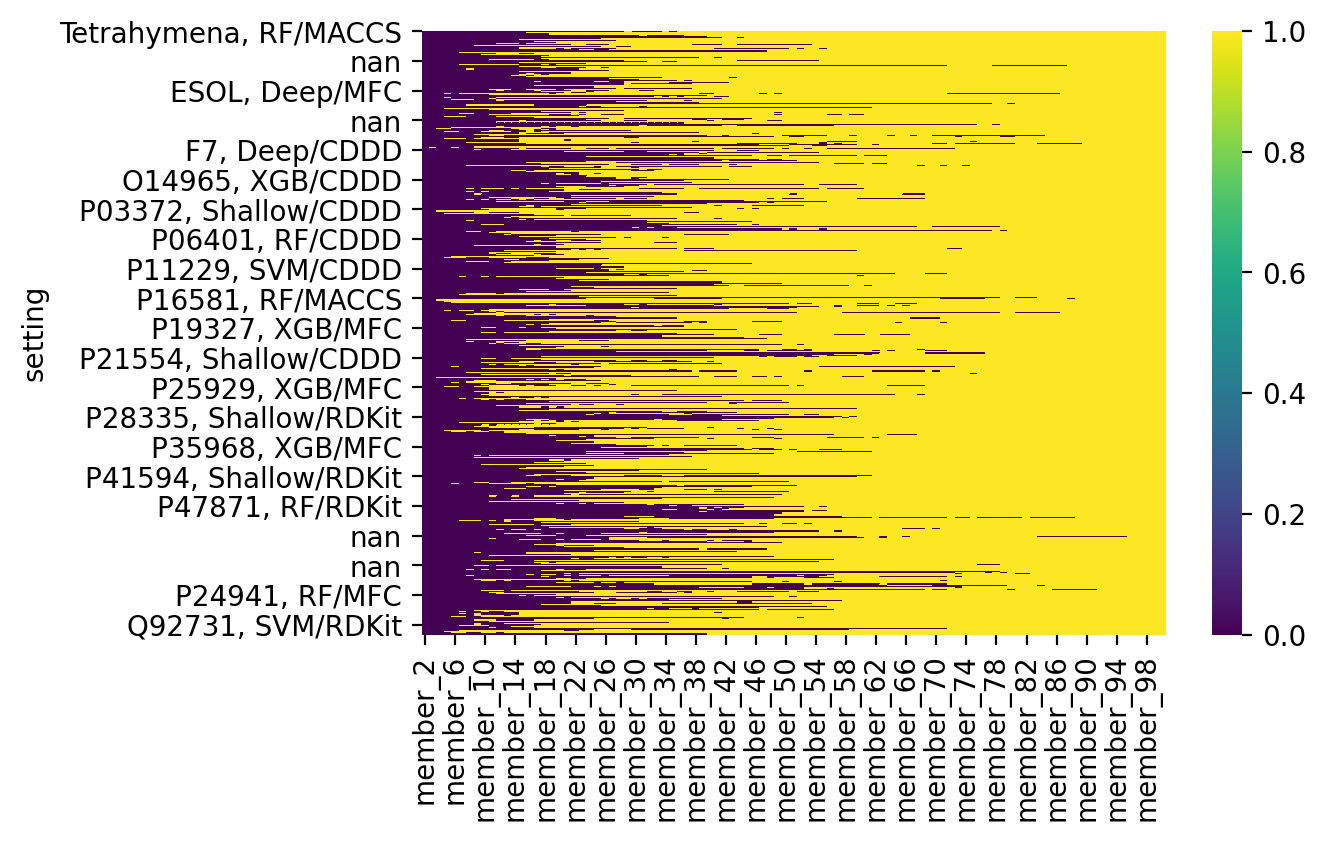

In [11]:
sns.heatmap(unct_reached.T, cmap='viridis')
plt.show()

First members to reach 90% of the full ensemble predictive performance

In [12]:
pred_member_index = range(1, 101)
unct_member_index = range(2, 101)

pred_reached_array = pred_reached.T.to_numpy()
pred_first_member_which_reached_90 = list()

for setting in pred_reached_array:
    for i, member in zip(pred_member_index, setting):
        if member:
            pred_first_member_which_reached_90.append(i)
            break

In [13]:
print(f'The median for the number of members to reach 90% of the max. pred. performance first is {np.median(pred_first_member_which_reached_90):.0f}.')

The median for the number of members to reach 90% of the max. pred. performance first is 9.


Plot histogram

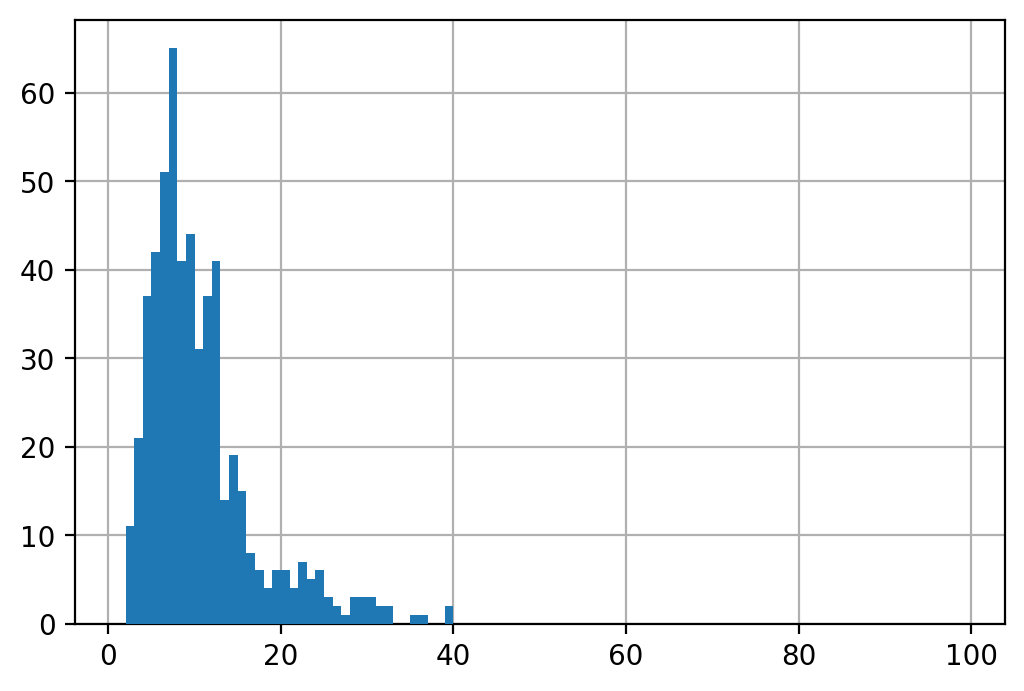

In [14]:
plt.grid(zorder=1000)
plt.hist(pred_first_member_which_reached_90, bins=initial_bins, zorder=100)
plt.show()

First members to reach 90% of the full ensemble uncertainty performance

In [15]:
unct_reached_array = unct_reached.T.to_numpy()
unct_first_member_which_reached_90 = list()

for setting in unct_reached_array:
    for i, member in zip(unct_member_index, setting):
        if member:
            unct_first_member_which_reached_90.append(i)
            break

In [16]:
print(f'The median for the number of members to reach 90% of the max. unct. performance first is {np.median(unct_first_member_which_reached_90):.0f}.')

The median for the number of members to reach 90% of the max. unct. performance first is 20.


Plot histogram

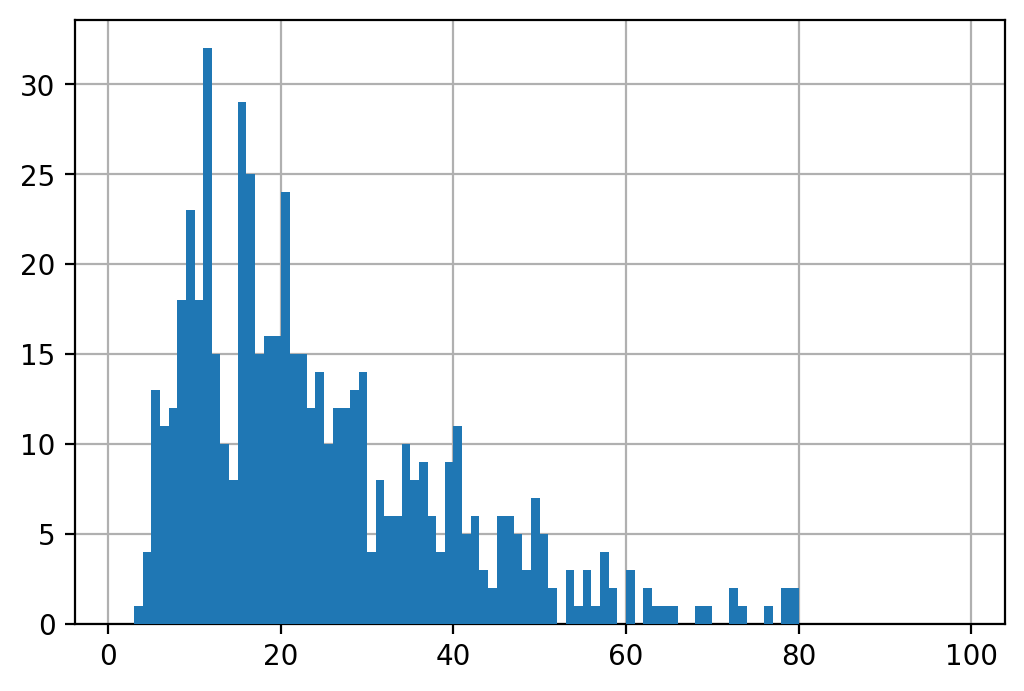

In [17]:
plt.grid(zorder=1000)
plt.hist(unct_first_member_which_reached_90, bins=initial_bins, zorder=100)
plt.show()

Plot comprehensive graphic for publication

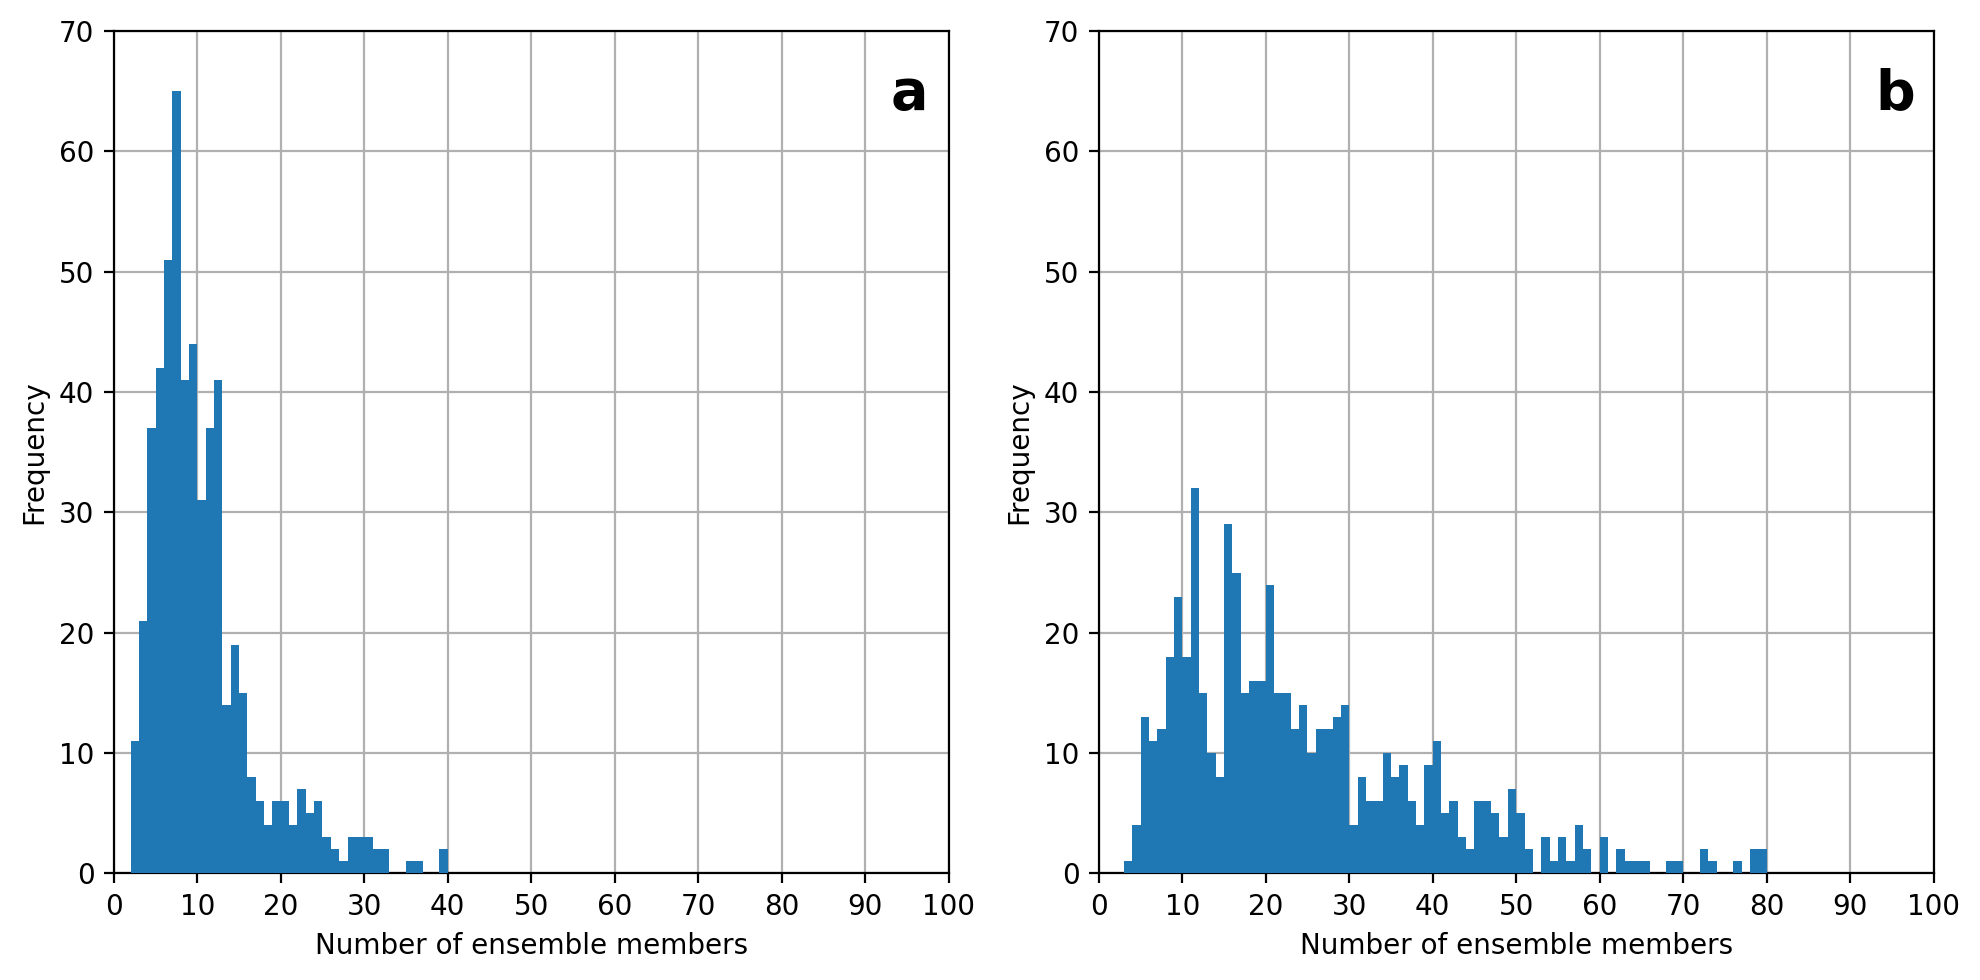

In [18]:
fig, (ax_pred, ax_unct) = plt.subplots(1, 2, figsize=(10, 5))#, frameon=True)
image_path = f'{PLOT_FOLDER}histograms/first_members_to_reach_90_percent_of_100_members.pdf'

ax_pred.grid(zorder=1000)
hi_pred, bins_pred, _ = ax_pred.hist(pred_first_member_which_reached_90, bins=range(1, 100), zorder=100)
#ax_pred.set_title('Predictive performance')
ax_pred.set_xlabel('Number of ensemble members')
ax_pred.set_ylabel('Frequency')
ax_pred.set_xlim((0, 100))
ax_pred.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax_pred.set_ylim((0, 70))
ax_pred.text(93, 63.5, 'a', fontsize=20, weight='bold')

ax_unct.grid(zorder=1000)
hi_unct, bins_unct, _ = ax_unct.hist(unct_first_member_which_reached_90, bins=bins_pred, zorder=100)
#ax_unct.set_title('Uncertainty performance')
ax_unct.set_xlabel('Number of ensemble members')
ax_unct.set_ylabel('Frequency')
ax_unct.set_xlim((0, 100))
ax_unct.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax_unct.set_ylim((0, 70))
ax_unct.text(93, 63.5, 'b', fontsize=20, weight='bold')

fig.tight_layout()
plt.savefig(image_path, bbox_inches='tight', pad_inches=0.05)
plt.show()

Plot comprehensive cumulative graphic for publication

In [19]:
# Preliminary calculations

pred_cumulative = [sum(hi_pred[:i]) for i in range(len(hi_pred))]
unct_cumulative = [sum(hi_unct[:i]) for i in range(len(hi_unct))]

pred_cumulative_density = pred_cumulative / max(pred_cumulative)
unct_cumulative_density = unct_cumulative / max(unct_cumulative)

# Get full 100 values range
pred_cumulative_density = np.append(pred_cumulative_density, [1., 1.], 0)
unct_cumulative_density = np.append(unct_cumulative_density, [1., 1.], 0)

# Members at >= .5 probability density:
pred_over_05 = np.argmax(np.array(pred_cumulative_density) >= .5)
unct_over_05 = np.argmax(np.array(unct_cumulative_density) >= .5)

# Members at >= .9 probability density:
pred_over_09 = np.argmax(np.array(pred_cumulative_density) >= .9)
unct_over_09 = np.argmax(np.array(unct_cumulative_density) >= .9)

# Members at >= 1. probability density:
pred_over_1 = np.argmax(np.array(pred_cumulative_density) >= 1.)
unct_over_1 = np.argmax(np.array(unct_cumulative_density) >= 1.)

pred_thresh = [pred_over_05, pred_over_09, pred_over_1]
unct_thresh = [unct_over_05, unct_over_09, unct_over_1]

# Assign bar colors:
pred_bar_colors = ['red' if index in pred_thresh else 'C0' for index in range(len(pred_cumulative_density))]
unct_bar_colors = ['red' if index in unct_thresh else 'C0' for index in range(len(unct_cumulative_density))]

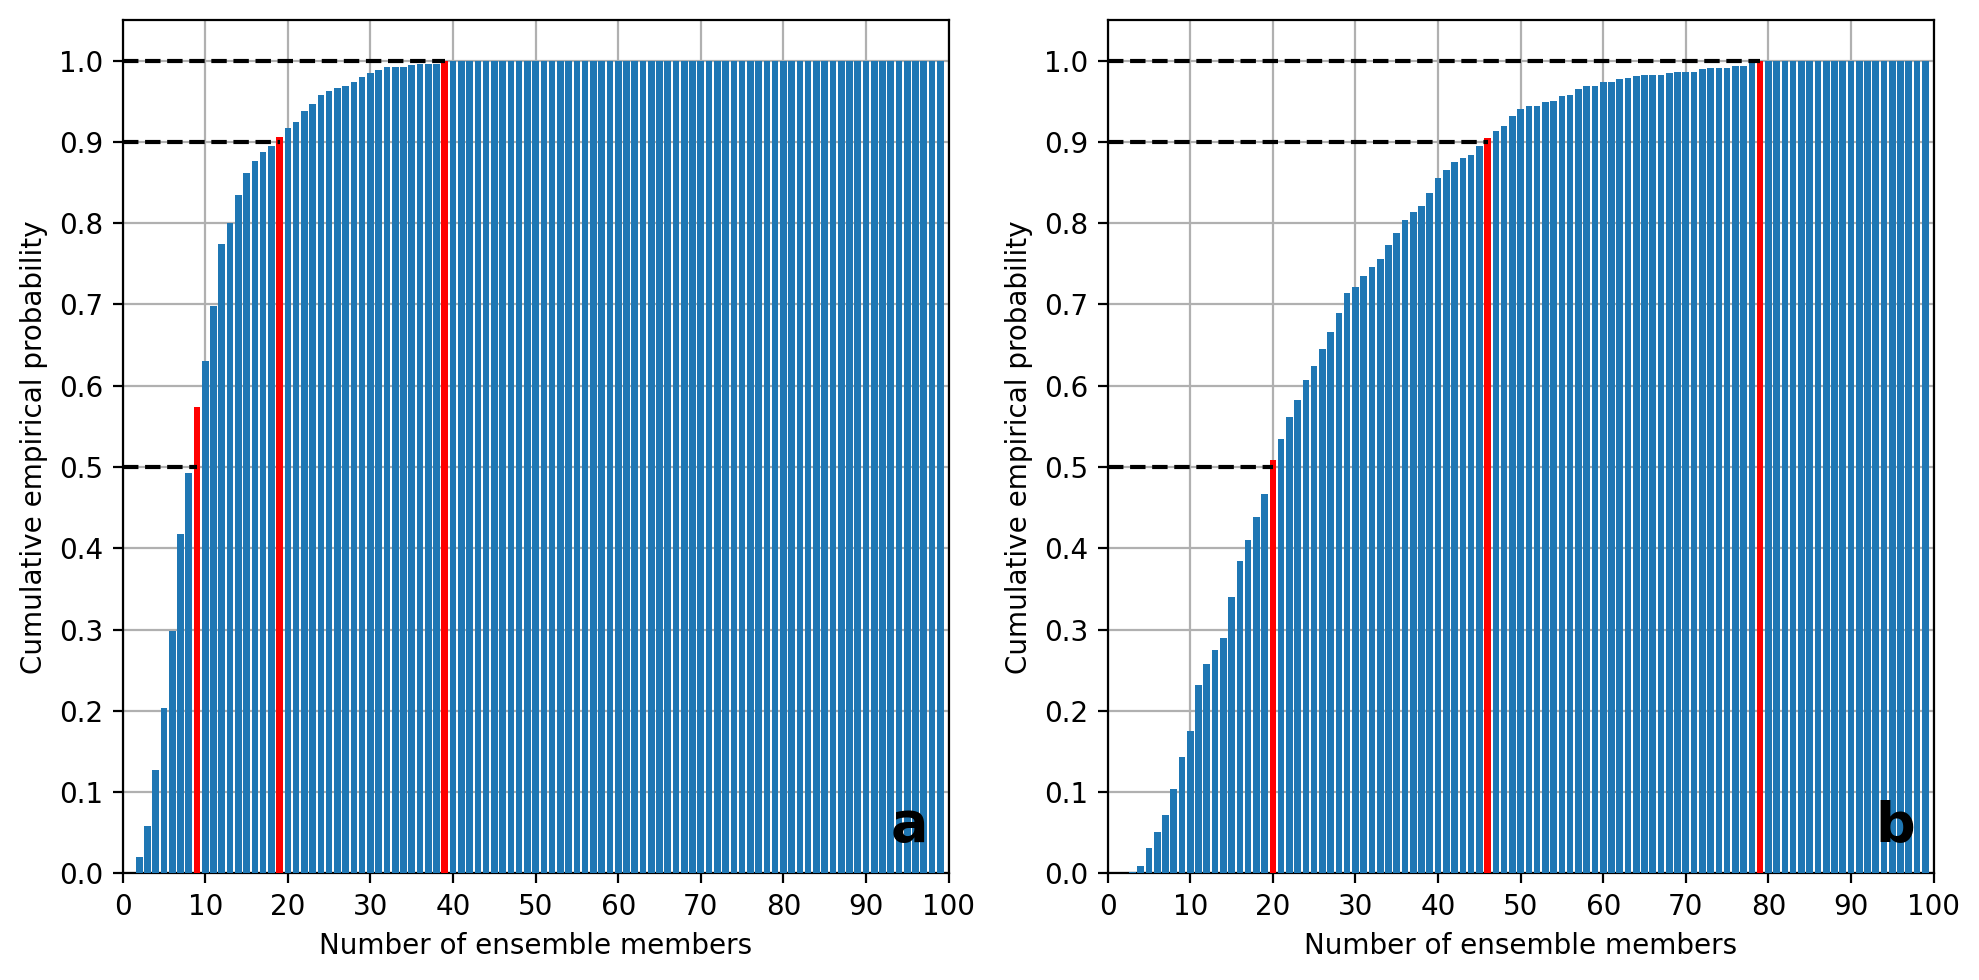

In [20]:
fig, (ax_pred, ax_unct) = plt.subplots(1, 2, figsize=(10, 5))
image_path = f'{PLOT_FOLDER}histograms/first_members_to_reach_90_percent_of_100_members_cumulative.pdf'

ax_pred.grid(zorder=1000)
ax_pred.bar(range(len(pred_cumulative_density)), pred_cumulative_density, .8, color=pred_bar_colors, zorder=100)
ax_pred.hlines(.5, 0, 9, color='black', linestyle='--', zorder=101)
ax_pred.hlines(.9, 0, 19, color='black', linestyle='--', zorder=101)
ax_pred.hlines(1., 0, 39, color='black', linestyle='--', zorder=101)
#ax_pred.set_title('Predictive performance')
ax_pred.set_xlabel('Number of ensemble members')
ax_pred.set_ylabel('Cumulative empirical probability')
ax_pred.set_xlim((0, 100))
ax_pred.set_ylim((0, 1.05))
ax_pred.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax_pred.set_yticks([0., .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.])
ax_pred.text(93, .04, 'a', fontsize=20, weight='bold', zorder=100000)

ax_unct.grid(zorder=1000)
ax_unct.bar(range(len(unct_cumulative_density)), unct_cumulative_density, .8, color=unct_bar_colors, zorder=100)
ax_unct.hlines(.5, 0, 20, color='black', linestyle='--', zorder=101)
ax_unct.hlines(.9, 0, 46, color='black', linestyle='--', zorder=101)
ax_unct.hlines(1., 0, 79, color='black', linestyle='--', zorder=101)
#ax_unct.set_title('Uncertainty performance')
ax_unct.set_xlabel('Number of ensemble members')
ax_unct.set_ylabel('Cumulative empirical probability')
ax_unct.set_xlim((0, 100))
ax_unct.set_ylim((0, 1.05))
ax_unct.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax_unct.set_yticks([0., .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.])
ax_unct.text(93, .04, 'b', fontsize=20, weight='bold', zorder=100000)

fig.tight_layout()
plt.savefig(image_path, bbox_inches='tight', pad_inches=0.05)
plt.show()

In [21]:
print(f'Required ensemble sizes for pred: {pred_thresh}')
print(f'Required ensemble sizes for unct: {unct_thresh}')

Required ensemble sizes for pred: [9, 19, 39]
Required ensemble sizes for unct: [20, 46, 79]


Plot inverted cumulative probability densities

In [22]:
fig, (ax_pred, ax_unct) = plt.subplots(1, 2, figsize=(10, 5))
image_path = f'{PLOT_FOLDER}histograms/first_members_to_reach_90_percent_of_100_members_cumulative.pdf'

ax_pred.grid(zorder=1000)
ax_pred.plot(pred_cumulative_density, range(len(pred_cumulative_density)), zorder=100)
ax_pred.set_xlabel('Number of ensemble members')
ax_pred.set_ylabel('Cumulative probability density')
ax_pred.set_xlim((0, 1.05))
ax_pred.set_ylim((0, 100))
ax_pred.set_xticks([0., .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.])
ax_pred.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax_pred.text(93, .04, 'a', fontsize=20, weight='bold', zorder=1000)

ax_unct.grid(zorder=1000)
ax_unct.plot(unct_cumulative_density, range(len(unct_cumulative_density)), zorder=100)
ax_unct.set_xlabel('Number of ensemble members')
ax_unct.set_ylabel('Cumulative probability density')
ax_unct.set_xlim((0, 1.05))
ax_unct.set_ylim((0, 100))
ax_unct.set_xticks([0., .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.])
ax_unct.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax_unct.text(93, .04, 'b', fontsize=20, weight='bold', zorder=1000)

fig.tight_layout()
#plt.savefig(image_path, bbox_inches='tight', pad_inches=0.05)
plt.show()

<ipython-input-22-6f90e1e22504>:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
